In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 
import plotly.graph_objects as go

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import dash
import dash_core_components as dcc
from dash import html
from dash.dependencies import Input, Output,State

sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)


<ipython-input-1-e6353b19bdef>:17: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc


# Data set cleaned for Covid-19 modelling

In [2]:
# try to parse the dates right at the beginning 
# it works out of the box if the date was stored ISO YYYY-MM-DD format


df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')  
df_analyse.sort_values('date',ascending=True)

,date,Italy,Kazakhstan,Armenia
0,2020-01-22,0,0,0
1,2020-01-23,0,0,0
2,2020-01-24,0,0,0
3,2020-01-25,0,0,0
4,2020-01-26,0,0,0
...,...,...,...,...
873,2022-06-13,17664043,1395061,423006
874,2022-06-14,17703887,1395068,423044
875,2022-06-15,17736696,1395085,423044
876,2022-06-16,17773764,1395102,423044


In [3]:
## Nice mathematical explanation of the differential SIR 
# https://www.youtube.com/watch?v=NKMHhm2Zbkw

In [4]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate

## beta/gamma is the basic reproduction number, <1 means no spread virus


# condition I0+S0+R0=N0
I0=df_analyse.Armenia[39]
S0=N0-I0
R0=0

In [5]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


# Simulative approach to calculate SIR curves

In [6]:
SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


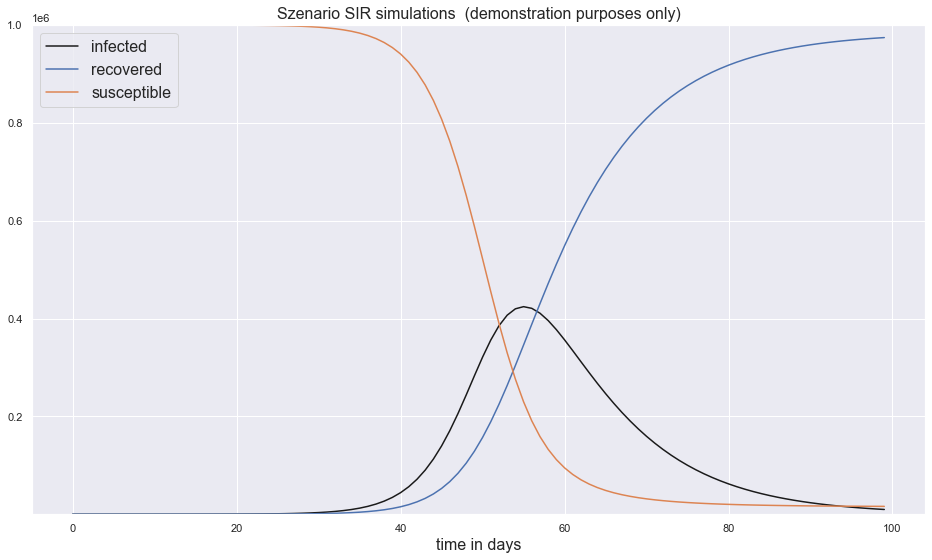

In [7]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Fitting data to a model

In [8]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [9]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [10]:
## fit the data set ydata, here the simulative data set of the infected curve

ydata = propagation_rates.infected
t=np.arange(len(ydata))

In [11]:
#ydata

In [12]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.00082611 0.00079504]  start infect: 1.2999996
Optimal parameters: beta = 0.36948380584826046  and gamma =  0.09588335097056114


<ipython-input-8-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-8-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\ASUS\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [13]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

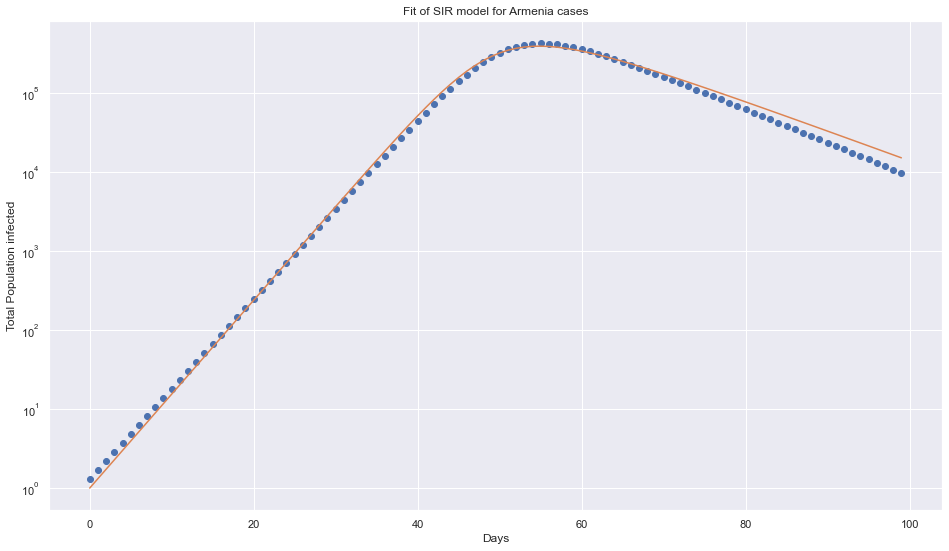

Optimal parameters: beta = 0.36948380584826046  and gamma =  0.09588335097056114
Basic Reproduction Number R0  3.8534719751472
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [14]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
#plt.semilogy(fitted)

plt.title("Fit of SIR model for Armenia cases")
plt.ylabel("Total Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Fitting the parameters of SIR model

In [15]:
## slice out some true data of a country

ydata = np.array(df_analyse.Armenia[40:150])
t=np.arange(len(ydata))

In [16]:
# ensure re-initialization 
# attenion when slicing gout only a time window 
# (one Corana wave) the overall N0 is not the full popoulation size 
N0=10000000

I0=ydata[0]
S0=N0-I0
R0=0
print('start infected:',I0)
print('cumulative sum of invected after period',ydata[-1])
print('Number of days',len(ydata))
print('N0',N0)

start infected: 1
cumulative sum of invected after period 19157
Number of days 110
N0 10000000


In [17]:
## get the model parameters / fit the model
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

# get the final fitted curve / predict the outcome 
fitted=fit_odeint(t, *popt)

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-8-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-8-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\ASUS\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


standard deviation errors :  [0.0244105  0.02409627]  start infect: 1
Optimal parameters: beta = 1.8281756029920126  and gamma =  1.7224835187553142


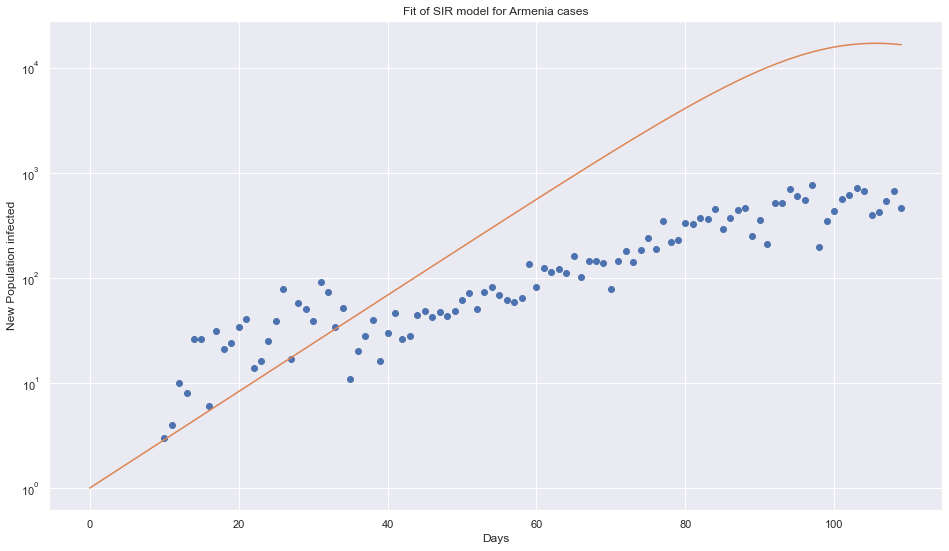

Optimal parameters: beta = 1.8281756029920126  and gamma =  1.7224835187553142
Basic Reproduction Number R0  1.0613602876810528
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [18]:
# option 1: ydata is cummulative, thus we need cumulative fitted line
#plt.semilogy(t, ydata, 'o') 
#plt.semilogy(t, np.cumsum(fitted))

# option2: ydata is cummulative, however we would like to have the day to day difference
plt.semilogy(t,np.ediff1d(ydata, to_begin=ydata[1]-ydata[0]), 'o')
plt.semilogy(t, fitted)

plt.title("Fit of SIR model for Armenia cases")
plt.ylabel("New Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

# Dynamic Dashboard

In [19]:
data_path='../data/raw/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [20]:
pd_raw = pd.read_csv(data_path)
country_list = pd_raw['Country/Region'].unique()
date=pd_raw.columns[4:]
df_analyse=pd.DataFrame({'Date':date})

for each in country_list:
    df_analyse[each] = np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0)).T

df_analyse.to_csv('../data/raw/COVID-19/csse_covid_19_data/SIR.csv',index=False)

In [21]:
df_analyse

,Date,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Winter Olympics 2022,Yemen,Zambia,Zimbabwe
0,1/22/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1/23/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2,1/24/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
3,1/25/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
4,1/26/20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,7/24/22,184587,304890,266839,45326,102301,11,8736,9507562,424400,...,967808,242691,11723,532902,10767948,672039,535,11849,328550,256254
915,7/25/22,184819,305123,266916,45326,102301,11,8736,9507562,425365,...,967808,242747,11723,533195,10768844,672039,535,11849,329483,256270
916,7/26/22,185086,306789,267010,45326,102301,11,8741,9507562,425365,...,969803,242811,11723,533195,10770304,682096,535,11849,329483,256284
917,7/27/22,185272,308050,267096,45326,102301,11,8741,9507562,425365,...,969803,242879,11723,533379,10772980,682096,535,11849,329483,256315


# Initializing basic Parameters

In [22]:
N0=1000000 #max susceptible population as shown in the lecture not accurate
beta=0.4   # infection spread 
gamma=0.1  # recovery rate

df_data=df_analyse[58:]
t=np.arange(df_data.shape[0])

R0=0
    
for country in df_data.columns[1:]:
    y_data=np.array(df_data[df_data[country]>0][country])
    t=np.arange(len(y_data))

    I0=y_data[0]
    S0=N0-I0
    popt=[0.4,0.1]
    fit_odeint(t, *popt)
    popt, pcov = optimize.curve_fit(fit_odeint, t, y_data, maxfev=5000)
    perr = np.sqrt(np.diag(pcov))
    fitted=fit_odeint(t, *popt)
    fitted_pad = np.concatenate((np.zeros(df_data.shape[0]-len(fitted)) ,fitted))
    df_data[country + '_fitted'] = fitted_pad

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-22-817b95e46961>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data[country + '_fitted'] = fitted_pad
<ipython-input-8-16f200073f8a>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0          #S*I is the
<ipython-input-8-16f200073f8a>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
C:\Users\ASUS\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 5000.

In [ ]:
df_data = df_data.reset_index(drop=True)
df_data.to_csv('../data/processed/SIR_fitted_curve.csv')

In [ ]:
# creating dashboard app containig plotting of source and fitted SIR curve data for whole dataset
fig = go.Figure()
app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  SIR Model Dashboard
    * The first plot shows the confirmed cases with time.
    * The second plot shows the predicted cases with time. 
    
    '''),

    dcc.Markdown('''
    ## Select Country
    '''),
    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in df_data.columns[1:200]],
        value=['Italy','Kazakhstan','Armenia'], # which are pre-selected
        multi=True),
    dcc.Graph(figure=fig, id='main_window_slope')])


@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value')])
def update_figure(country_list):
    v = 0
    my_yaxis={'type':"log",'title':'Confirmed'}
    traces = []
    for each in country_list:
        traces.append(dict(x=df_data['Date'],y=df_data[each],
                                mode='line',name=each))
        traces.append(dict(x=df_data['Date'],
                                y=df_data[each+'_fitted'],
                                mode='lines+markers',name=each+'_simulated'))

        v = v+1
    return {
            'data': traces,
            'layout': dict (
                width=1280,height=720,
                xaxis={'title':'Time','tickangle':-45,'nticks':20,
                'tickfont':dict(size=14,color="#0c6887"),},yaxis=my_yaxis)}

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
